In [1]:
import numpy as np
from scipy.spatial import distance
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def load_dataset(name):
    path = os.path.join("..", "datasets", name)
    data = pd.read_csv(path)
    data = data.values
    xs = data[:, 1:]
    return xs

In [3]:
xs = load_dataset("tsp.csv")

In [4]:
def path_len(xs):
    return np.array([distance.cityblock(xs[i - 1], xs[i]) for i in range(1, xs.shape[0])]).sum()

In [5]:
def draw(xs, name):
    plt.cla()
    
    plt.scatter(xs[:, 0], xs[:, 1],  c='r')
    path = np.array([[xs[i // 2][0], xs[i // 2 + i % 2][1]] for i in range(2 * xs.shape[0] - 1)])
    plt.plot(path[:, 0], path[:, 1])

    plt.title("{}, path length = {}".format(name, path_len(xs)))

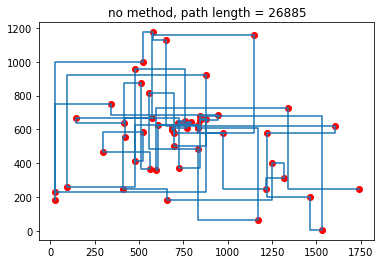

In [6]:
draw(xs,
     "no method")

In [7]:
def monte_carlo(xs, itrs):
    xs = xs.copy()
    best_xs = xs.copy()
    best_l = path_len(xs)
    
    for i in range(itrs):
        np.random.shuffle(xs)
        l = path_len(xs)
        if best_l > l:
            best_xs, best_l = xs.copy(), l
            
    return best_xs

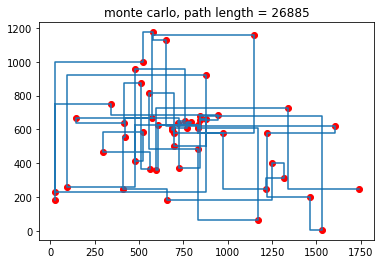

In [8]:
draw(monte_carlo(xs, 100000),
     "monte carlo")

In [9]:
def random_walk(xs, itrs):
    n = xs.shape[0]
    xs = xs.copy()
    best_xs = xs.copy()
    best_l = path_len(xs)
    
    for i in range(itrs):
        a, b = np.random.choice(n, 2, replace=False)
        if a > b:
            a, b = b, a
            
        xs = np.concatenate((xs[:a], xs[a:b][::-1], xs[b:]), axis=0)
        l = path_len(xs)
        if best_l > l:
            best_xs, best_l = xs.copy(), l
            
    return best_xs

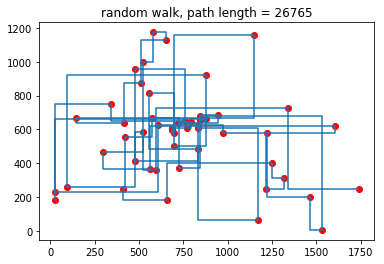

In [10]:
draw(random_walk(xs, 100000),
     "random walk")

In [11]:
def hill_climb(xs, itrs):
    n = xs.shape[0]
    xs = xs.copy()
    l = path_len(xs)
    for i in range(itrs):
        new_x = xs.copy()
        
        update = False
        for a in range(n):
            for b in range(a + 1, n):
                txs = np.concatenate((xs[:a], xs[a:b][::-1], xs[b:]), axis=0)
                tl = path_len(txs)
                if l > tl:
                    new_xs, l = txs, tl
                    update = True
                    
        if not update:
            break
            
        xs = new_xs
    return xs

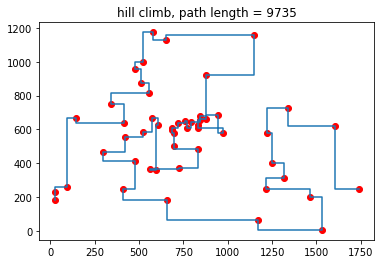

In [12]:
draw(hill_climb(xs, 100000),
     "hill climb")

In [13]:
def simulated_annealing(xs, itrs, t_max, t_min):
    n = xs.shape[0]
    xs = xs.copy()
    best_xs = xs.copy()
    best_l = l = path_len(xs)
    
    t = t_max
    for i in range(itrs):
        t = t_min + (t_max - t_min) * (itrs - 1 - i) / (itrs - 1)
        
        a, b = np.random.choice(n, 2, replace=False)
        if a > b:
            a, b = b, a
        new_xs = np.concatenate((xs[:a], xs[a:b][::-1], xs[b:]), axis=0)
        new_l = path_len(new_xs)
        
        if l > new_l:
            xs, l = new_xs, new_l
        else:
            p = np.exp(-(new_l - l) / t)
            r = np.random.uniform()
            if r < p:
                xs, l = new_xs, new_l
        
        if best_l > l:
            best_xs, best_l = xs.copy(), l
            
    return best_xs

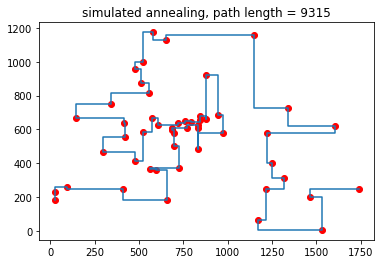

In [14]:
draw(simulated_annealing(xs, 100000, 100, 0.0001),
     "simulated annealing")

In [15]:
def genetic(xs, itrs, sz, mut):    
    n = xs.shape[0]
    
    def cross(x, y):
        k = np.random.choice(n - 1, 1)[0]
        new_x, new_y = x[:k].copy(), y[:k].copy()
        new_x, new_y = np.array(new_x), np.array(new_y)
        for i in range(n):
            if y[i].tolist() not in new_x.tolist():
                new_x = np.concatenate((new_x, [y[i].copy()]), axis=0)
            if x[i].tolist() not in new_y.tolist():
                new_y = np.concatenate((new_y, [x[i].copy()]), axis=0)
        return new_x, new_y
    
    def mutate(x):
        x = x.copy()
        for i in range(n - 1):
            r = np.random.uniform()
            if (r < mut):
                j = np.random.choice(range(i + 1, n), 1)[0]
                x = np.concatenate((x[:i], x[i:j][::-1], x[j:]), axis=0)
        return x
    
    pop = np.array([np.random.permutation(xs) for i in range(sz)])
    pop_l = np.array([path_len(pop[i]) for i in range(sz)])
    
    best_i = np.argsort(pop_l)[0]
    best_xs, best_l = pop[best_i].copy(), pop_l[best_i]
    
    for i in range(itrs):
        a, b = np.argsort(pop_l)[:2]
        x, y = cross(pop[a], pop[b])
        x, y = mutate(x), mutate(y)
        
        indxs = np.argsort(pop_l)[-2:]
        pop[indxs] = x, y
        pop_l[indxs] = path_len(x), path_len(y)
        
        best_i = np.argsort(pop_l)[0]
        if best_l > pop_l[best_i]:
            best_xs, best_l = pop[best_i].copy(), pop_l[best_i]
            
    return best_xs

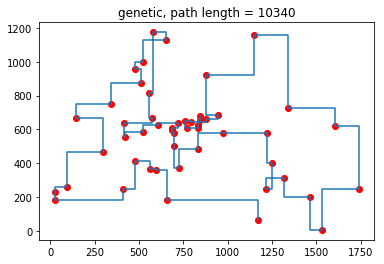

In [16]:
draw(genetic(xs, 100000, 20, 0.01),
     "genetic")